In [1]:
import numpy as np

import os
import gzip
import matplotlib.pyplot as plt
import sys
import time


import argparse
import sys
#import tempfile

FLAGS = None

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
kernel_num = 8

In [8]:
def cnn(x):

  # reshape 
  with tf.name_scope('input_reshaped_layer'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # convolutional layer 1
  with tf.name_scope('conv_layer_1'):
    W1 = tf.Variable(tf.truncated_normal([3, 3, 1, kernel_num], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[kernel_num]))
    h1 = tf.nn.conv2d(x_image, W1, strides=[1, 1, 1, 1], padding='SAME')
    h1 = tf.nn.relu(h1 + b1)

  # maxpooling layer 1
  with tf.name_scope('maxpool_layer_1'):
    hp1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # convolutional layer 2
  with tf.name_scope('conv_layer_2'):
    W2 = tf.Variable(tf.truncated_normal([3, 3, kernel_num, kernel_num], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[kernel_num]))
    h2 = tf.nn.conv2d(hp1, W2, strides=[1, 1, 1, 1], padding='SAME')
    h2 = tf.nn.relu(h2 + b2)

  # Mmaxpooling layer 2
  with tf.name_scope('maxpool_layer_2'):
    hp2 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # fully connected layer 1 
  with tf.name_scope('fully_connected_layer'):
    h_flat = tf.reshape(hp2, [-1, 7*7*kernel_num])
    W3 = tf.Variable(tf.truncated_normal([7 * 7 * kernel_num, 128], stddev=0.1))
    b3 = tf.Variable(tf.constant(0.1, shape=[128]))
    
    h3 = tf.nn.relu(tf.matmul(h_flat, W3) + b3)

  # Map the 128 features to 10 classes, one for each digit
  with tf.name_scope('output_layer'):
    W4 = tf.Variable(tf.truncated_normal([128, 10], stddev=0.1))
    b4 = tf.Variable(tf.constant(0.1, shape=[10]))
    
    y_hat = tf.matmul(h3, W4) + b4
    
  return y_hat


In [9]:

valid_acc_arr =  []
train_acc_arr =  [] 



def main(_):
  
  #mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


  
  x = tf.placeholder(tf.float32, [None, 784])
  y_ = tf.placeholder(tf.float32, [None, 10])

 
  y_hat = cnn(x)



  with tf.name_scope('loss_cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_hat)
  cross_entropy = tf.reduce_mean(cross_entropy)


  #GradientDescentOptimizer
  with tf.name_scope('GradientDescent'):
    train_step = tf.train.GradientDescentOptimizer(1e-1).minimize(cross_entropy)
    
  #it's faster
  #with tf.name_scope('adam_optimizer'):
  #  train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)

  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)


  graph_location = "/home/tsapenko/Documents/Lab2/mnist_convnet_model"
  print('Saving to: %s' % graph_location)
  train_writer = tf.summary.FileWriter(graph_location)
  train_writer.add_graph(tf.get_default_graph())
   



  config = tf.ConfigProto(
    device_count = {'GPU': 0})
  sess = tf.Session(config=config)
  

  with sess as sess:
    sess.run(tf.global_variables_initializer())
    t0 = time.time()
    for i in range(500):
      batch = mnist.train.next_batch(50)
      valid_acc = accuracy.eval(feed_dict={x: mnist.test.images[0:5000,:], y_: mnist.test.labels[0:5000,:]})
      valid_acc_arr.append(valid_acc)
      if i % 10 == 0:
            
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training accuracy %g' % (i, train_accuracy))
        print('step %d, validation accuracy %g' % (i, valid_acc))
      train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
    # I have used 5k samples for validation from the test set and 5k samples for test
    t1 = time.time()
    test_acc = accuracy.eval(feed_dict={x: mnist.test.images[5000:10001,:], y_: mnist.test.labels[5000:10001,:]})
    print('test accuracy %g' % test_acc)
    t1 = time.time()
    print('Duration: {:.1f}s'.format(t1-t0))

if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--data_dir', type=str,
                      default='/tmp/tensorflow/mnist/input_data',
                      help='Directory for storing input data')
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

Saving to: /home/tsapenko/Documents/Lab2/mnist_convnet_model
step 0, training accuracy 0.1
step 0, validation accuracy 0.0854
step 10, training accuracy 0.18
step 10, validation accuracy 0.225
step 20, training accuracy 0.36
step 20, validation accuracy 0.437
step 30, training accuracy 0.56
step 30, validation accuracy 0.4804
step 40, training accuracy 0.86
step 40, validation accuracy 0.7246
step 50, training accuracy 0.8
step 50, validation accuracy 0.727
step 60, training accuracy 0.84
step 60, validation accuracy 0.8174
step 70, training accuracy 0.72
step 70, validation accuracy 0.751
step 80, training accuracy 0.86
step 80, validation accuracy 0.8172
step 90, training accuracy 0.82
step 90, validation accuracy 0.7876
step 100, training accuracy 0.88
step 100, validation accuracy 0.8492
step 110, training accuracy 0.8
step 110, validation accuracy 0.895
step 120, training accuracy 0.86
step 120, validation accuracy 0.8892
step 130, training accuracy 0.94
step 130, validation accur

SystemExit: 

/home/tsapenko/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [153]:
valid_acc_arr4=np.copy(valid_acc_arr)

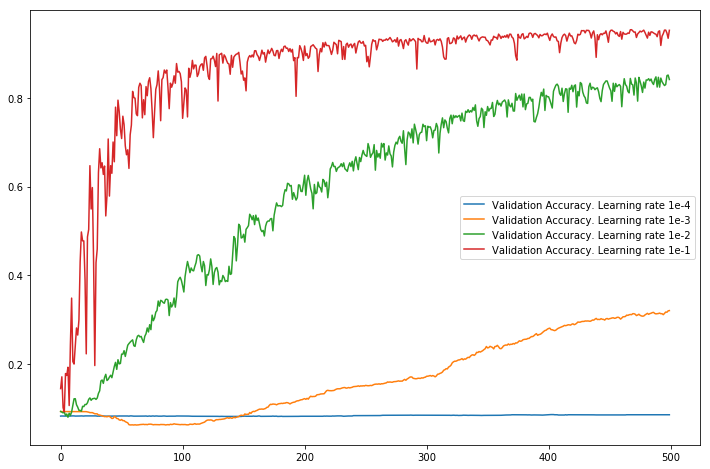

In [154]:
#print(valid_acc_arr)


plt.figure(figsize=(12, 8))

plt.plot(valid_acc_arr4, label='Validation Accuracy. Learning rate 1e-4')
plt.plot(valid_acc_arr3, label='Validation Accuracy. Learning rate 1e-3')
plt.plot(valid_acc_arr2, label='Validation Accuracy. Learning rate 1e-2')
plt.plot(valid_acc_arr1, label='Validation Accuracy. Learning rate 1e-1')
plt.legend(loc='best')    
plt.show()    

[52376, 104368, 211808, 440512, 953216, 2199808]
[178, 271, 441, 1174, 3040, 10995]


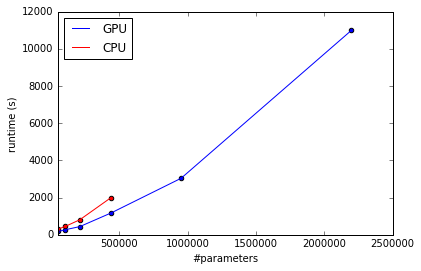

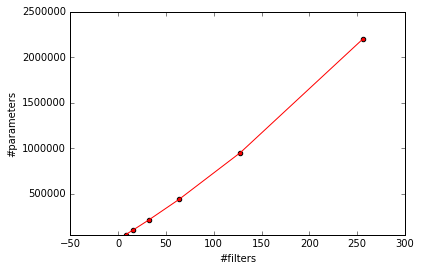

In [29]:
param_num=[]
filters = [8, 16, 32, 64, 128, 256]
duration_gpu = [178, 271, 441, 1174, 3040, 10995]
for f in filters:
    s = 0
    #conv_layer_1
    s+=(3*3*1+1)*f
    #conv_layer_2
    s+=(3*3*f+1)*f
    # fully connected layer 1 
    s+=(7*7*f+1)*128
    # output layer
    s+=(10+1)*128
    param_num.append(s)
print(param_num)
print(duration_gpu)
plt.plot(param_num,duration_gpu,label='GPU')
plt.scatter(param_num,duration_gpu)
plt.ylim(0, 12000)
plt.xlim(50000, 2500000)
plt.xlabel("#parameters")
plt.ylabel("runtime (s)")
#plt.title("GPU")
#plt.show()


duration_cpu = [305, 447, 809, 2001]
plt.ylim(0, 12000)
plt.xlim(50000, 2500000)
plt.plot(param_num[:4],duration_cpu,c='r',label='CPU')
plt.scatter(param_num[:4],duration_cpu,c='r')
plt.xlabel("#parameters")
plt.ylabel("runtime (s)")
#plt.title("CPU")
plt.legend(loc='best')  
plt.show()
    
    
    
plt.plot(filters,param_num,c='r')
plt.scatter(filters,param_num,c='r')
plt.ylim(0, 300)
plt.ylim(50000, 2500000)
plt.ylabel("#parameters")
plt.xlabel("#filters")

plt.show()